In [279]:
import pandas as pd
import pickle,os, copy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys


import re

from sklearn.cluster import DBSCAN


from nn_generalizability.nets import Nets
from nn_generalizability.utils import *
from nn_generalizability.postprocessing.postprocessing import *
from nn_generalizability.postprocessing.stats_plotting import *
from nn_generalizability.postprocessing.GA import *
from nn_generalizability.save_load import *

from nn_generalizability.postprocessing.sharpness_measures import *
from nn_generalizability.postprocessing.stats_plotting import *

from nn_generalizability.data_getters import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (13,9)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
root_folder = os.environ["PATH_TO_GEN_FOLDER"]
data_name = "CIFAR10"
exp = "SimpleNet_high_steps"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)

In [130]:
# get all sorts of data
exp_dict = {}

def get_stuff(experiment_folder):
    stuff = {}

    stuff_to_try = ["tsne", "runs", "trace", "acc", "dist", "loss", "grad", "eig"]

    for singular_stuff in stuff_to_try:
        print("Getting {}.".format(singular_stuff))
        data, meta = load_cached_data(experiment_folder, singular_stuff)
        if data is None:
            print("Error: {} could not be found".format(singular_stuff))
        else:
            stuff[singular_stuff] = data
    
    stuff["configs"] = load_configs(experiment_folder)
    
    return stuff

exp_dict["stuff"] = get_stuff(experiment_folder)
exp_dict["models"] = get_all_models(experiment_folder, -1)
exp_dict["resampling_idxs"] = get_sample_idxs(experiment_folder)

Getting tsne.
Error: tsne could not be found
Getting runs.
Getting trace.
Getting acc.
Getting dist.
Error: dist could not be found
Getting loss.
Getting grad.
Error: grad could not be found
Getting eig.
Error: eig could not be found


In [139]:
max_idx = {'1594672291.0710459': '0',
          '1594673313.8724134': '1',
          '1594678537.6570415': '0'}

In [175]:
def subset(d, max_idx):
    return {k: {"0": v[max_idx[k]]} for k, v in d.items()}

In [143]:
subset(exp_dict["stuff"]['acc'], max_idx)

{'1594672291.0710459': (0.95368, 0.5051),
 '1594673313.8724134': (1.0, 0.5218),
 '1594678537.6570415': (1.0, 0.5125)}

In [144]:
subset(exp_dict["stuff"]['loss'], max_idx)

{'1594672291.0710459': (0.1412724256515503, 3.4875659942626953),
 '1594673313.8724134': (3.432107769185677e-05, 6.252953052520752),
 '1594678537.6570415': (4.437526877154596e-05, 6.731678009033203)}

In [145]:
p_t = {k1 : {k2: (np.mean(v2), np.std(v2)) for k2, v2 in v1.items()} for k1, v1 in exp_dict["stuff"]['trace'].items()}
subset(p_t, max_idx)


{'1594672291.0710459': (322.3327941894531, 9.104748222571002),
 '1594673313.8724134': (5.044191211462021, 0.4091231964255127),
 '1594678537.6570415': (15.6140567779541, 0.31375507791645935)}

In [131]:
stats_df = get_end_stats(exp_dict)


Error: No stats for 1594678537.6570415
YO
Error: No stats for 1594673313.8724134
YO
Error: No stats for 1594672291.0710459
YO


In [132]:
# stats_df = stats_df[stats_df["Acc Test Mean"] > 0.15]
stats_df.sort_values(by="Acc Test Max", ascending=False)

,Acc Test Max,Acc Test Mean,Acc Test Min,Acc Train Max,Acc Train Mean,Acc Train Min,Gap Mean,Loss Test Max,Loss Test Mean,Loss Test Min,...,Loss Train Mean,Loss Train Min,Norm Max,Norm Mean,Norm Min,Trace Max,Trace Mean,Trace Mean Std,Trace Min,batch_train_size
1594673313.8724134,0.5218,0.52050,0.5192,1.00000,1.00000,1.00,-0.47950,6.284950,6.268951,6.252953,...,0.000034,0.000034,35.086926,35.047825,35.008724,5.102764,5.073478,0.422046,5.044191,256
1594678537.6570415,0.5125,0.51240,0.5123,1.00000,1.00000,1.00,-0.48760,6.762398,6.747038,6.731678,...,0.000044,0.000043,30.368324,30.281442,30.194559,16.183148,15.898602,0.903751,15.614057,4096
1594672291.0710459,0.5051,0.49945,0.4938,0.95368,0.95184,0.95,-0.45239,3.561881,3.524724,3.487566,...,0.147665,0.141272,87.128716,86.997990,86.867264,339.959930,331.146362,7.278381,322.332794,32


In [21]:
point_traces = get_exp_point_traces(experiment_folder, step=-1, seed=0, num_datapoints=50, on_test_set=False, should_cache=False)


Files already downloaded and verified
Files already downloaded and verified


In [154]:
point_traces, meta = load_cached_data(experiment_folder, "point_traces")

In [10]:
set_seed(10)


# get data
train_data, test_data = get_postprocessing_data(experiment_folder, vectorized=True)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)  # fix the batch size
full_train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)  # fix the batch size

test_loader = DataLoader(test_data, batch_size=1)

criterion = torch.nn.CrossEntropyLoss()

data = next(iter(train_loader))


Files already downloaded and verified
Files already downloaded and verified


In [238]:
def get_exp_margins(experiment_folder, softmax_outputs=False, step=-1, seed=0, device=None, num_datapoints=50, on_test_set=False, should_cache=False):
    margins_dict = {}
    meta_dict = {"seed": seed}

    # get data
    train_data, test_data = get_data_from_experiment(experiment_folder)
    if on_test_set:
        data = get_random_data_subset(test_data, num_datapoints=num_datapoints, seed=seed)
    else:
        data = get_random_data_subset(train_data, num_datapoints=num_datapoints, seed=seed)


    set_seed(seed)
    # iterate through models
    for exp_name, curr_path in exp_models_path_generator(experiment_folder):

        models_dict = get_models(curr_path, step)
        margins_dict[exp_name] = get_margins_to_correct(models_dict, data, device=device, softmax_outputs=softmax_outputs)

        # cache data
        if should_cache:
            cache_data(experiment_folder, "margins", margins_dict, meta_dict)

    return margins_dict

In [269]:


def entropy(probs):
    return - np.sum([p * np.log(p) for p in probs])

def get_entropy(net, data, device=None):
    inputs, labels = data

    outputs = get_model_outputs(net, data, softmax_outputs=True, device=device)
    outputs = outputs.detach().numpy()
    
    return [entropy(p) for p in outputs]

# def get_max_margin(net, datapoint):
#     inp, l = datapoint
    
#     loss = criterion(outputs, labels)
#     loss.backward(retain_graph=True)
    
#     param_grads = get_grad_params_vec(net)
#     curr_weight = torch.norm(param_grads)
        
# def get_nu(data):
#     tr = 0
#     for i in range(len(data[0])):
#         inputs, labels = data[0][i], data[1][i]
#         mean_inp = torch.mean(inputs)

#         for j in range()
    

def get_margins_to_correct(models, data, device=None, softmax_outputs=False):
    margins_filters = {}
    if device is not None:
        is_gpu = True
    else:
        is_gpu = False

    for k, m in models.items():
        
        inputs, labels = data
        if device is not None:
                inputs, labels = inputs.to(device).type(torch.cuda.FloatTensor), labels.to(device).type(
                    torch.cuda.LongTensor)

        outputs = get_model_outputs(m, data, softmax_outputs, device)

        _, predicted = torch.max(outputs, 1)

        correct_filter = predicted == labels
        
        # if correctly predicted
        second_largest = torch.topk(outputs, k=2, dim=1)
        

        curr_margins = second_largest[0][:, 0] - second_largest[0][:, 1]
        
        # we override the ones which were incorrectly predicted
        curr_margins[~correct_filter] = second_largest[0][:, 0][~correct_filter] - torch.Tensor(take_slice(outputs, labels))[~correct_filter]
        
        
        curr_margins = curr_margins.detach().numpy()
        correct_filter = correct_filter.detach().numpy()
        
        margins_filters[k] = (curr_margins, correct_filter)
    return margins_filters
    






In [418]:
margins_filters = get_exp_margins(experiment_folder, softmax_outputs=True, step=-1, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
margins = {k1: {k2: v2[0] for k2, v2 in v1.items()} for k1, v1 in margins_filters.items()}


Files already downloaded and verified
Files already downloaded and verified


In [419]:
margins_filters_filtered = subset(margins_filters, max_idx)
point_traces_filtered = subset(point_traces, max_idx)

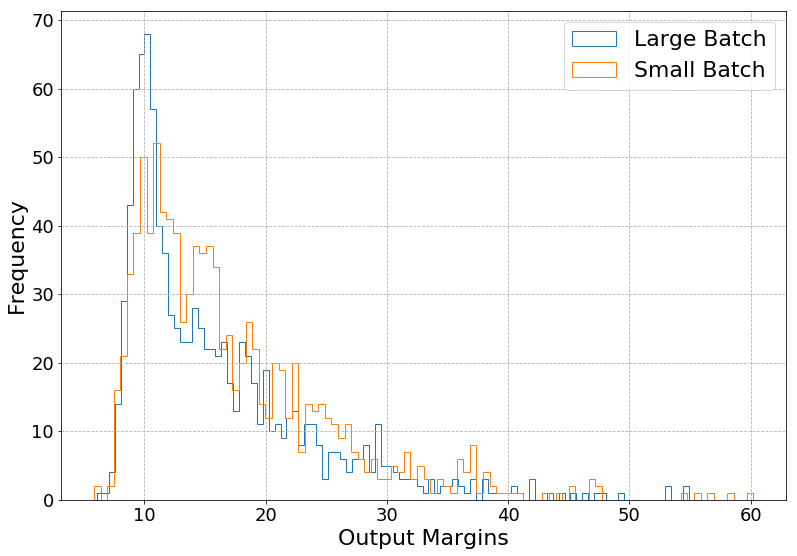

In [391]:
def hist_plot(margins_filters):
    def xy_func(exp_ids, plots, plots_names, comb):
        h = []
        
        for exp_id in exp_ids:
            for model_idx in margins_filters[exp_id].keys():

                margins, correct_filters = margins_filters[exp_id][model_idx]
                h.append(margins)
        

        h = np.concatenate(h, axis=0)

        
        if 256 in comb:
#             plots_names.append("Small Batch")
            plots.append(plt.hist(h, bins=100, histtype='step', label="Small Batch"))

        else:
#             plots_names.append("Large Batch")
            plots.append(plt.hist(h, bins=100, histtype='step', label="Large Batch"))
#         plots.append(plt.hist(h, bins=100))

        
        return plots, plots_names
        
    return xy_func



hp_xy_func_plot(experiment_folder, hist_plot(margins_filters_filtered), 
                X_axis_name="Output Margins", Y_axis_name="Frequency", plot_name="Histogram",
                filter_seperate=None, filter_not_seperate=["batch_train_size"],
                 save_exp_path=experiment_folder, X_axis_bounds=None, Y_axis_bounds=None,
                pre_filtered_exp_ids=['1594673313.8724134', '1594678537.6570415'])
# 


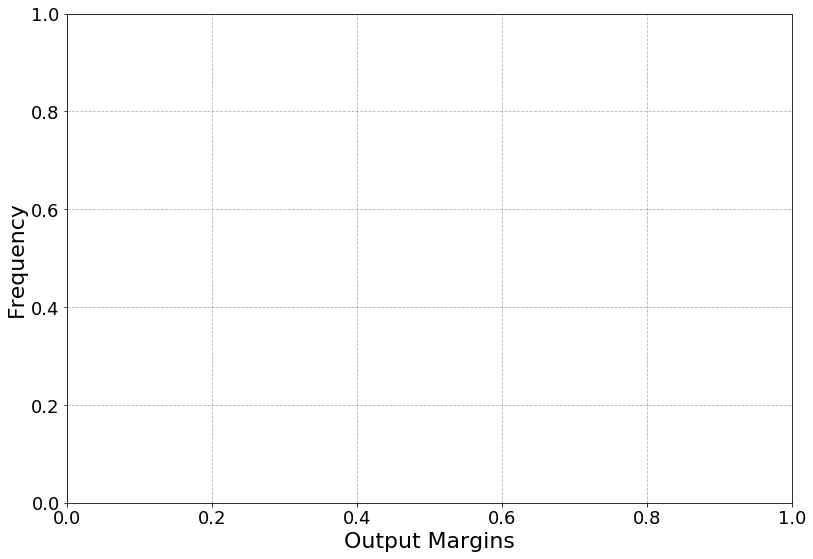

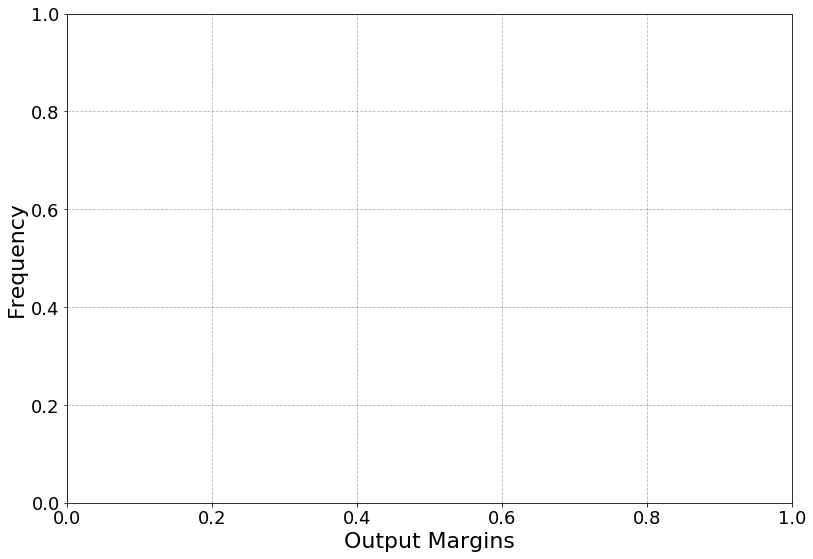

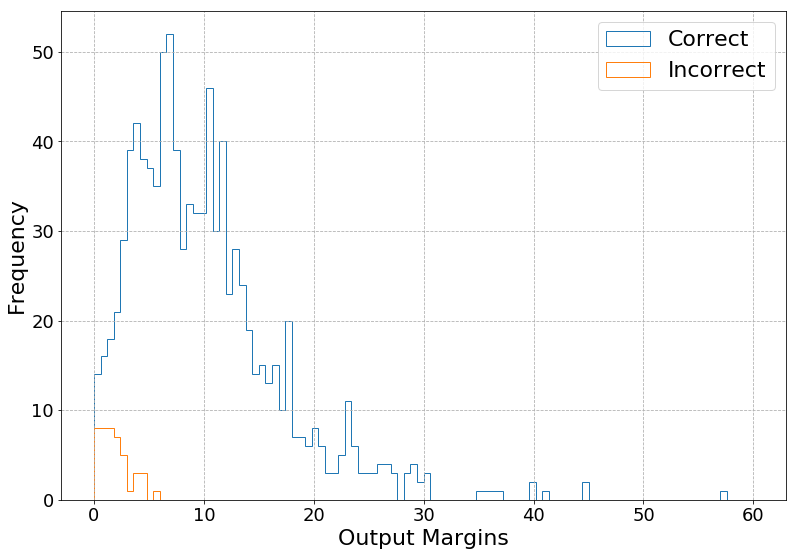

In [409]:
def correct_incorrect_hist_plot(margins_filters):
    def xy_func(exp_ids, plots, plots_names, comb=None):
        x_correct = []

        x_incorrect = []
        for exp_id in exp_ids:
            for model_idx in margins_filters[exp_id].keys():

                margins, correct_filters = margins_filters[exp_id][model_idx]

                x_correct.append(margins[correct_filters])

                x_incorrect.append(margins[~correct_filters])

        x_correct = np.concatenate(x_correct, axis=0)

        x_incorrect = np.concatenate(x_incorrect, axis=0)

        
        if len(x_correct) > 0:
            plots.append(plt.hist(x_correct, bins=100, range=[0, 60], histtype='step', label="Correct"))

        if len(x_incorrect) > 0:
            plots.append(plt.hist(x_incorrect, bins=100, range=[0, 60], histtype='step', label="Incorrect"))
            
        return plots, plots_names
        
    return xy_func

hp_xy_func_plot(experiment_folder, correct_incorrect_hist_plot(margins_filters_filtered), 
                X_axis_name="Output Margins", Y_axis_name="Frequency", plot_name="Correct_Incorrect_Histogram",
                filter_seperate=["batch_train_size"], filter_not_seperate=None,
                 save_exp_path=experiment_folder, X_axis_bounds=None, Y_axis_bounds=None, 
                pre_filtered_exp_ids=["1594672291.0710459"],)

1


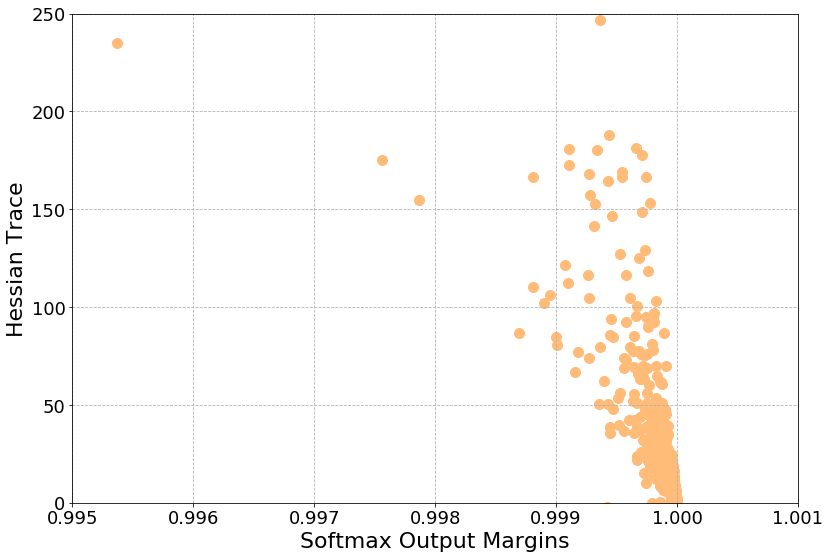

1


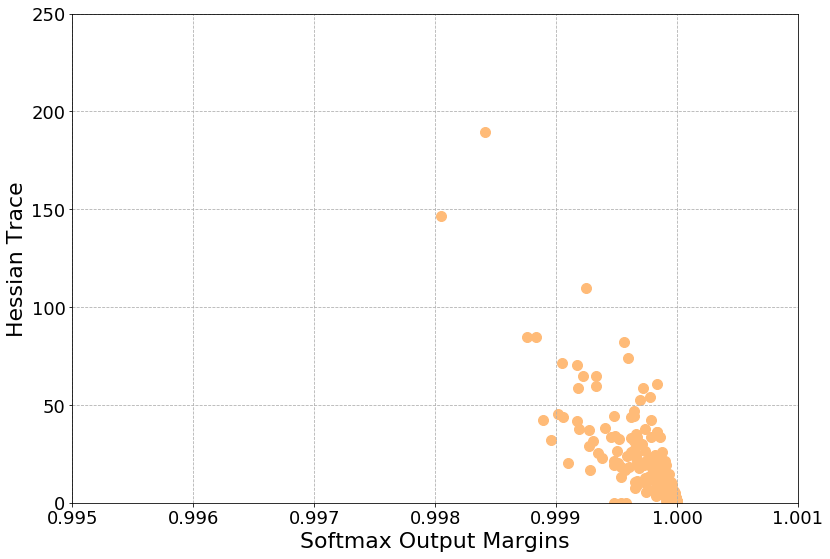

2


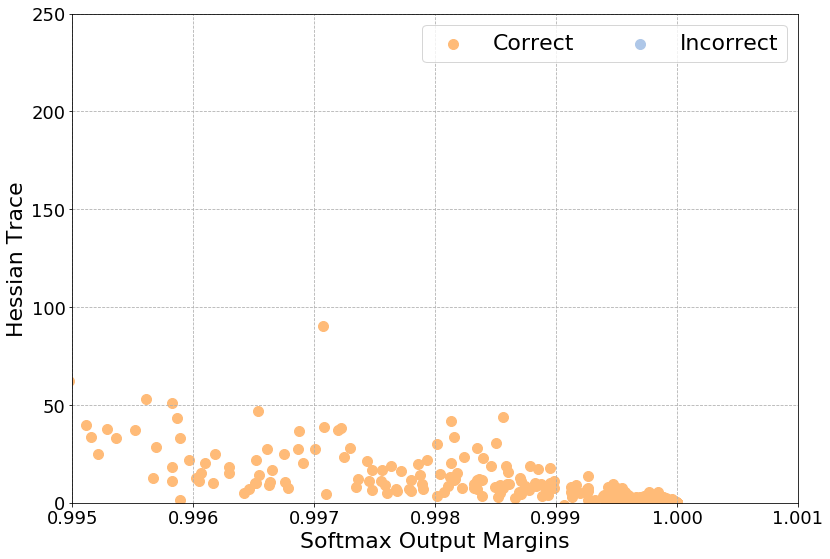

In [423]:
def correct_incorrect_plot(margins_filters, point_traces):
    def xy_func(exp_ids, plots, plots_names, comb=None):
        x_correct = []
        y_correct = []

        x_incorrect = []
        y_incorrect = []
        for exp_id in exp_ids:
            for model_idx in margins_filters[exp_id].keys():

                margins, correct_filters = margins_filters[exp_id][model_idx]
                curr_point_traces = np.array(point_traces[exp_id][model_idx])

                x_correct.append(margins[correct_filters])
                y_correct.append(curr_point_traces[correct_filters])

                x_incorrect.append(margins[~correct_filters])
                y_incorrect.append(curr_point_traces[~correct_filters])

        x_correct = np.concatenate(x_correct, axis=0)
        y_correct = np.concatenate(y_correct, axis=0)

        x_incorrect = np.concatenate(x_incorrect, axis=0)
        y_incorrect = np.concatenate(y_incorrect, axis=0)

        if len(x_correct) > 0:
            plots.append(plt.scatter(x_correct.T, y_correct.T))
            plots_names.append("Correct")

        if len(x_incorrect) > 0:
            plots.append(plt.scatter(x_incorrect.T, y_incorrect.T))
            plots_names.append("Incorrect")
        
        return plots, plots_names
        
    return xy_func



hp_xy_func_plot(experiment_folder, correct_incorrect_plot(margins_filters_filtered, point_traces_filtered), 
                X_axis_name="Softmax Output Margins", Y_axis_name="Hessian Trace", plot_name="Softmax_Correct_Incorrect",
                filter_seperate=["batch_train_size"], filter_not_seperate=None,
                 save_exp_path=experiment_folder, X_axis_bounds=[0.995, 1.001], Y_axis_bounds=[0, 250], pre_filtered_exp_ids=None,)


In [159]:
m1 = np.array(margins["1594673313.8724134"]["0"])
t1 = np.array(point_traces["1594673313.8724134"]["0"])

m2 = np.array(margins["1594678537.6570415"]["0"])
t2 = np.array(point_traces["1594678537.6570415"]["0"])

m3 = np.array(margins["1594672291.0710459"]["0"])
t3 = np.array(point_traces["1594672291.0710459"]["0"])

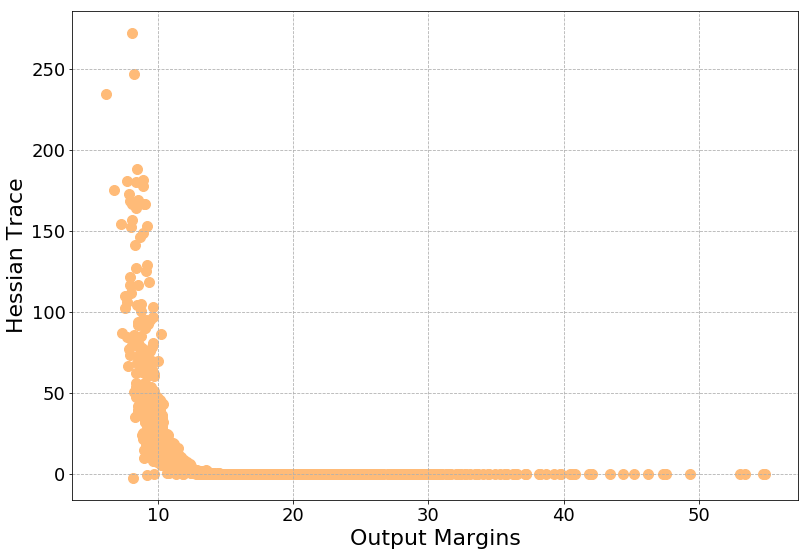

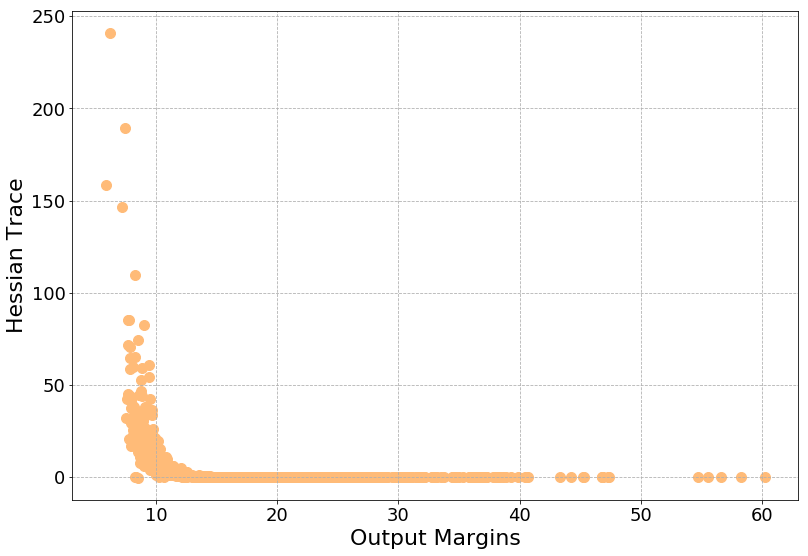

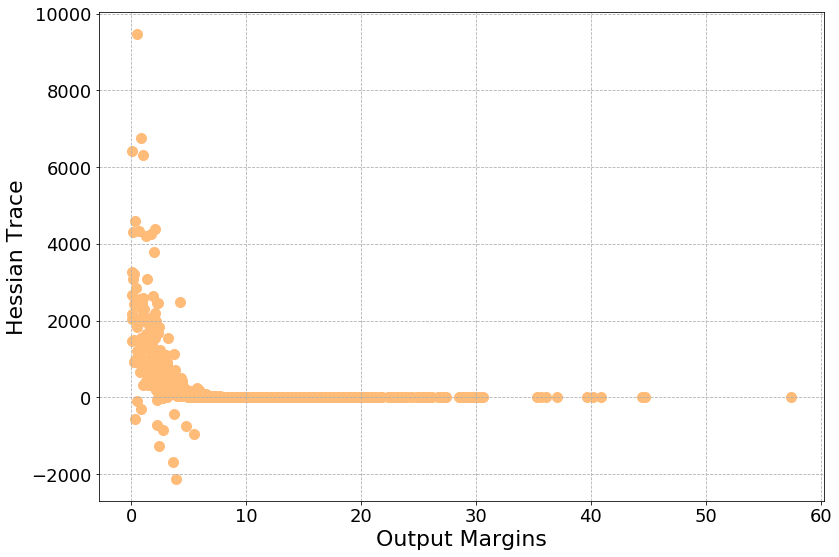

In [313]:

X_data = subset(margins, max_idx)
Y_data = subset(point_traces, max_idx)

hp_plot(experiment_folder, X_data, Y_data, X_axis_name="Output Margins", Y_axis_name="Hessian Trace", filter_seperate=["batch_train_size"], filter_not_seperate=None,
                 save_exp_path=experiment_folder, X_axis_bounds=None, Y_axis_bounds=None, pre_filtered_exp_ids=None,)

In [ ]:
plt.scatter(m1, t1, color="lightblue") # small batch
plt.scatter(m2, t2, color="orange")
# plt.scatter(m3*85, t3*85**2, color="green") # 32 batch

plt.show()



In [172]:
def cutoffs(m1, m2, t1, t2):
    print("Trace sum first: {}".format(np.sum(t1)))
    print("Trace sum second: {}".format(np.sum(t2)))

    print()
    min_cutoff = min(min(m1), min(m2))
    max_cutoff = max(max(m1), max(m2))
    for cutoff in np.linspace(min_cutoff, max_cutoff, 20):
        print("Cutoff: {}".format(cutoff))
        f1 = m1 < cutoff
        t1 = np.array(t1)
        m1 = np.array(m1)
        s1 = np.sum(f1)
        print("Num Points first: {}".format(s1))
        print("Mean Margin first: {}".format(np.mean(m1[f1])))
        print("Mean Trace first: {}".format(np.mean(t1[f1])))

        f2 = m2 < cutoff
        t2 = np.array(t2)
        m2 = np.array(m2)
        s2 = np.sum(f2)
        print("Num Points second: {}".format(s2))
        print("Mean Margin second: {}".format(np.mean(m2[f2])))
        print("Mean Trace second: {}".format(np.mean(t2[f2])))



        print()

In [173]:
m1 = margins["1594673313.8724134"]["0"]
t1 = point_traces["1594673313.8724134"]["0"]

m2 = margins["1594678537.6570415"]["0"]
t2 = point_traces["1594678537.6570415"]["0"]

# cutoffs(m1, m2, t1, t2)

<function matplotlib.pyplot.show(*args, **kw)>

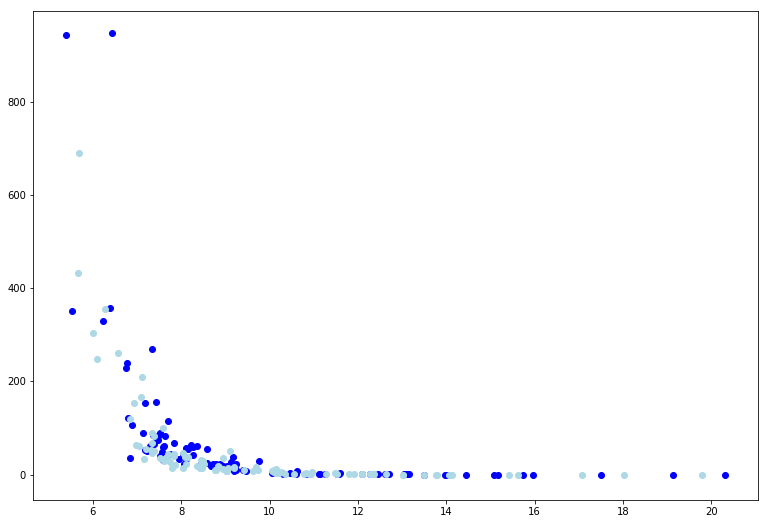

In [36]:
plt.scatter(diff, ts, color="lightblue")
plt.scatter(diff_1, ts_1, color="blue")


# plt.ylim(-0, 10)
# plt.xlim(0.006, 0.008)

plt.show